## Inventory Optimization: Case Study

In the world of supply chain management, accurately predicting future demand and optimizing inventory levels are critical for efficient operations and customer satisfaction.

The provided dataset contains historical data related to a specific product (Product_ID: P1) over a period of time. The data includes information on the date, product demand, and current inventory levels. This dataset serves as the foundation for analyzing demand forecasting and inventory optimization techniques.

**Your task is to:**

1. Utilize time series analysis to forecast the future demand for the given product (Product_ID: P1).
2. Generate accurate predictions for the next several days.
3. Calculate and implement safety stock levels to account for demand variability and uncertainties.
4. Determine the reorder point, which indicates when to replenish inventory based on forecasted demand and safety stock.
5. Apply the Economic Order Quantity (EOQ) concept to identify the optimal order quantity that minimizes total inventory costs.
6. Define the reorder cycle, representing the time interval between placing orders.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("demand_inventory.csv")
df.head()

,Unnamed: 0,Date,Product_ID,Demand,Inventory
0,0,2023-06-01,P1,51,5500
1,1,2023-06-02,P1,141,5449
2,2,2023-06-03,P1,172,5308
3,3,2023-06-04,P1,91,5136
4,4,2023-06-05,P1,198,5045


In [3]:
df.shape

(62, 5)

In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df.head()

,Date,Product_ID,Demand,Inventory
0,2023-06-01,P1,51,5500
1,2023-06-02,P1,141,5449
2,2023-06-03,P1,172,5308
3,2023-06-04,P1,91,5136
4,2023-06-05,P1,198,5045


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        62 non-null     object
 1   Product_ID  62 non-null     object
 2   Demand      62 non-null     int64 
 3   Inventory   62 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.1+ KB


In [10]:
df['Date']= pd.to_datetime(df['Date'], format= '%y/%m/%d')

##### Visualizing trends and patterns

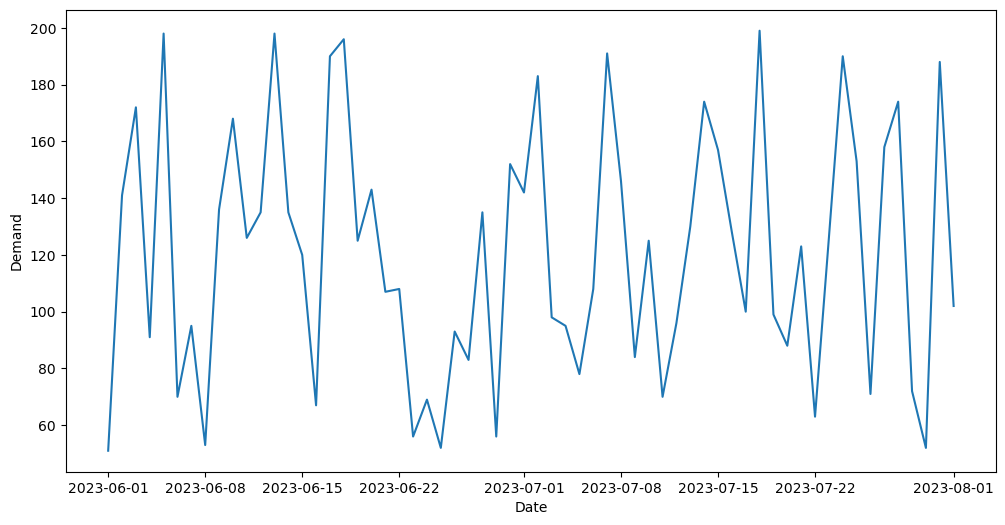

In [11]:
plt.figure(figsize=(12,6))
sns.lineplot( x = 'Date', y = 'Demand', data= df)
plt.show()

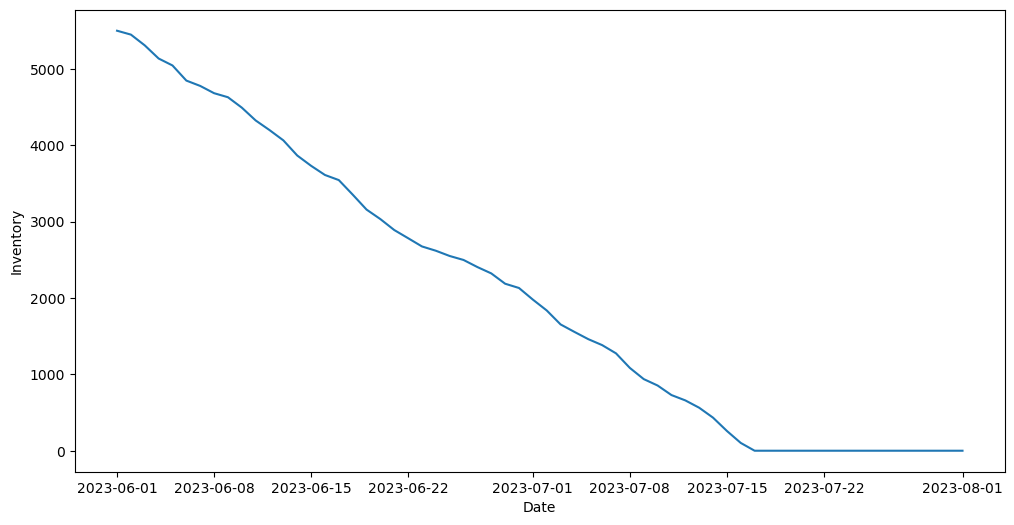

In [12]:
plt.figure(figsize=(12,6))
sns.lineplot(x = 'Date', y = 'Inventory', data = df)
plt.show()

#### Demand Forecasting

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [17]:
time_series = df.set_index('Date')['Demand']
differenced_series = time_series.diff().dropna()

##### Observing **Autocorrelation Function** and **Partial Autocorrelation Function** to find out the values of **"p"(Autoregressive Order)**, **"d"(Differencing Order)** and **"q"(Moving Average Oder)** that will help in forecasting using **SARIMA**

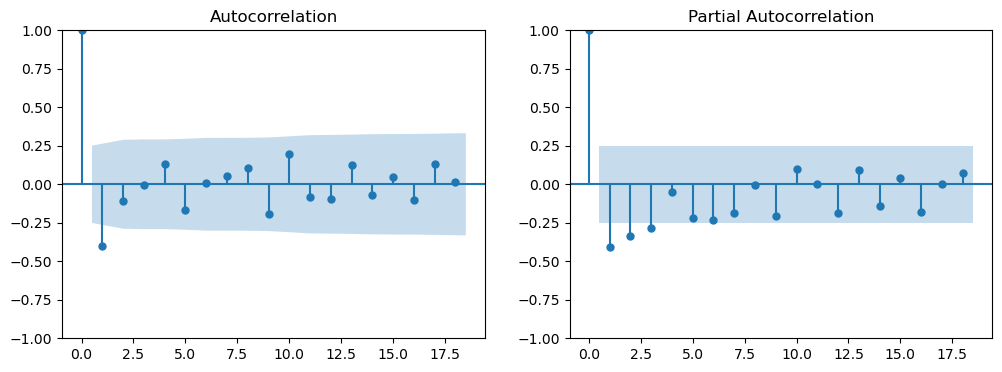

In [18]:
fig, axes = plt.subplots(1,2, figsize =(12,4))
plot_acf(differenced_series, ax = axes[0])
plot_pacf(differenced_series, ax= axes[1])
plt.show()

##### Build the SARIMA model to forecast the demand using "order" for non seasonal part of SARIMA and "seasonal order" seasonal part of SARIMA

In [19]:
order = (1,1,1)
seasonal_order = (1,1,1,2)
model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp = False)

In [22]:
future_steps = 10
predictions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)

2023-08-02    117
2023-08-03    116
2023-08-04    130
2023-08-05    114
2023-08-06    128
2023-08-07    115
2023-08-08    129
2023-08-09    115
2023-08-10    129
2023-08-11    115
Freq: D, Name: predicted_mean, dtype: int64


#### Inventory Management

In [23]:
future_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(days = 1), 
                             periods= future_steps, freq = 'D')
forcasted_demand = pd.Series(predictions, index = future_dates)

initial_inventory = 5500
lead_time = 1
service_level = 0.95


In [24]:
z = np.abs(np.percentile(forcasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forcasted_demand.mean() + z).astype(int)

In [28]:
print(z)
print(order_quantity)

114.45
236


In [25]:
reorder_point = forcasted_demand.mean() * lead_time + z
safety_stock = reorder_point - forcasted_demand.mean() * lead_time

In [29]:
print(reorder_point)
print(safety_stock)

235.25
114.45


In [26]:
holding_cost = 0.1
stockout_cost = 10
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forcasted_demand.mean() * lead_time - initial_inventory)
total_cost = total_holding_cost + total_stockout_cost

In [27]:
print('Optimal Order Quantity: ', order_quantity)
print('Reorder Point: ', reorder_point)
print('Safety Stock:', safety_stock)
print('Total Cost: ', total_cost)

Optimal Order Quantity:  236
Reorder Point:  235.25
Safety Stock: 114.45
Total Cost:  561.8000000000001


#### THANK YOU